In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization,Input,LeakyReLU,Activation
from tensorflow.keras.preprocessing import image
from keras.applications.vgg19 import VGG19,preprocess_input
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from tqdm import tqdm
import prettytable as pt
import os
import random
import time
import itertools

In [2]:
#GPU FOR TRAINGING
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Avaliable{}:".format(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

GPUs Avaliable[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]:


In [3]:
#define some functions

def join_path(root:str , *params)-> str:
    # give root and folders / files will return a path in str
    temp = root
    for p in params:
        temp = os.path.join(temp,p)
    return temp

#This will plot a binary or multiclass classification's confusion matrix
def plot_confusion_matrix(cm, classes
                          ,normalize = False
                          ,title='Confusion matrix'
                          ,cmap=plt.cm.Blues):
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontsize=12)
    plt.yticks(tick_marks,classes,fontsize=12)
    if normalize :
        cm = cm.astype('float') / cm.sum(axis=1)[:,np/newaxis]
        # print("Normalized confusion matrix")
    else :
        # print("Confusion matrix")
        pass
    # print(cm)
    
    thresh = cm.max() / 2.
    for i , j in itertools.product(range(cm.shape[0]),range(cm.shape[1])): 
        plt.text(j,i,cm[i,j],
                ha = "center",
                fontsize = 15,
                color = "orange" if cm[i,j]> thresh else "purple")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

def plot_multi_label_confusion_matrix(cm,classes,cmap=plt.cm.Blues) -> None:
    #give the whole ConfusionMatrix and classes and it will plot it out
    fig,ax = plt.subplots(2,int(len(cm)/2))
    count = 0
    for a,b in itertools.product(range(2),range(int(len(cm)/2))):


        thresh = cm[count].max() / 2.
        temp_cm = cm[count]
        class_ = classes[count]

        # plt.figure(figsize=(6,6))
        ax[a][b].imshow(temp_cm,interpolation='nearest',cmap=plt.cm.Blues)
        ax[a][b].set_title(class_)

        if(a == 0 and b==0):
            ax[a][b].set_yticks(np.arange(2),["TrueNegative , FalsePositive","FalseNegative , TruePositive "])
        else:
            ax[a][b].set_yticks([])

        ax[a][b].set_xticks([])
        for i,j in itertools.product(range(len(temp_cm[:][0])),range(len(temp_cm[0][:]))):
                ax[a][b].text(j,i,temp_cm[i][j],
                        ha = "center",
                        color = "orange" if temp_cm[i,j]> thresh else "purple")
        count += 1

def plot_acc_loss(acc,val_acc,loss,val_loss):
    #give values from fit history and it will plot out a graph
    plt.figure(figsize=(8,8))

    plt.subplot(2,1,1)
    plt.plot(acc,label="Trainging Accuracy")
    plt.plot(val_acc,label="Validation Accuracy")
    plt.legend(loc="upper left")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1])
    plt.title("Training and Validation Accuracy")

    plt.subplot(2,1,2)
    plt.plot(loss,label="Trainging Loss")
    plt.plot(val_loss,label="Validation Loss")
    plt.legend(loc="upper right")
    plt.ylabel("Cross Entropy")
    # plt.ylim([0,1.0]) #too high so let's not use this now
    plt.title("Trainging and Validation Loss")
    plt.xlabel("epoch")
    plt.show()

def plot_imgs(lots_imgs,lots_labels):
    # give 9 imgs and 9 lables,it will plot it out
    imgs = lots_imgs[:9]
    labels = lots_labels[:9]
    
    plt.figure(figsize=(15,15))
    for i in range(len(imgs)):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(imgs[i])
        plt.title(labels[i])
        plt.axis("off")

def convert_cm_to_container(cm):
    #give it a Multilabel Confusion Matrix and it will store it in a str, ez for storing in csv
    cm_container = str()
    if len(cm)==2:
        for i ,j in itertools.product(range(len(cm)),range(2)):
            cm_container += "{}_".format(cm[i,j])
    else:
        for i,j,k in itertools.product(range(len(cm)),range(2),range(2)):
            cm_container += "{}_".format(cm[i,j,k])
    return cm_container

def convert_container_to_cm(cm_container):
    #give it the str generate from function above,will return what it suppose to look like originally
    temp = cm_container.split(sep="_")
    size = int((len(temp)-1)/4)
    # print(size)
    if size == 4 or size == 6:
        c_cm = np.empty((size,2,2))
        count = -1
        for i,j,k in itertools.product(range(size),range(2),range(2)):
            count += 1
            # print(count)
            c_cm[i,j,k] = temp[count]
    elif size == 1:
        c_cm = np.empty((2,2))
        count = -1
        for i,j in itertools.product(range(2),range(2)):
            count += 1
            # print(count)
            c_cm[i,j] = temp[count]
    return c_cm

def convert_list_to_str(list_:list) -> str:
    temp = str()
    for item in list_:
        temp += "{}_".format(item)
    return temp

def convert_str_to_list(str_:str) -> list:
    list_ = list()
    str_ = str_.split(sep='_')
    for item in str_[:-1]:
        list_.append(float(item))
    return list_

def show_report(*nums, show_plot:bool=False):
    #give nums to choose which data to show,CAN give multiplay nums at once
    #if want to print out all history better use for loop with it
    #show_plot will control whether to plot ConfusionMatrix or not
    temp = list()
    history_report = pd.read_csv(report_csv_path)

    table = pt.PrettyTable()
    table.set_style(pt.DOUBLE_BORDER)
    table.hrules=pt.ALL
    temp.append('index')
    for num in nums:
        temp.append(num)
    table.field_names = temp

    for column in ["Date","Model","Batch_size","epochs","Learning_rate","Training_Report","DATA_TYPE","Note"]:
        temp = []
        temp.append(column)
        for num in nums:
            temp.append(history_report.iloc[num][column])
        table.add_row(temp)
    print(table)

    if show_plot == True:
        for num in nums:
            current_cm = convert_container_to_cm(history_report.iloc[num]['Confusion_Matrix'])
            # print(current_cm)
            if len(current_cm)==6:
                plot_multi_label_confusion_matrix(cm=current_cm,classes=['Benign', 'CC', 'Calc', 'MLO', 'Mass', 'Melignant'])
            elif len(current_cm)==4:
                plot_multi_label_confusion_matrix(cm=current_cm,classes=['Benign', 'Calc', 'Mass', 'Melignant'])
            elif len(current_cm)==2:
                plot_confusion_matrix(cm=current_cm,classes=['Benign','Malignant'])
                
            current_row = history_report.iloc[num]
            if current_row.isnull()['acc']==True:
                print('index:{} have no acuracy data for plotting accuracy.'.format(num))
                continue
            print("index:{}".format(num))
            acc = convert_str_to_list(current_row['acc'])
            val_acc = convert_str_to_list(current_row['val_acc'])
            loss = convert_str_to_list(current_row['loss'])
            val_loss = convert_str_to_list(current_row['val_loss'])
            # print(acc,'\n',val_acc,'\n',loss,'\n',val_loss)
            plot_acc_loss(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss)
                
            

In [4]:
#Variables and Constants
DATA_TYPE = "ALL" #options: ALL,CC,MLO
DATA_CLASS = ['Benign','Malignant']
model_name = "VGG" #Options: MobileNet,Inception,VGG,DenseNet
learning_rate = 1e-05
epochs = 30
BATCH_SIZE = 32
IMG_SIZE = (224,224,3)
show_detail = True


X_dataset = list()
IMG_DIR = "D:\\111project\\gitHub\\041-111project\\data\\Cropped_Calc_imgs"
report_csv_path = "D:\\111project\\gitHub\\041-111project\\data\\history_report_CalcOnly.csv"
data_csv_path = {"ALL":"D:\\111project\\gitHub\\041-111project\\data\\Calc_ALL.csv",
                 "CC":"D:\\111project\\gitHub\\041-111project\\data\\Calc_CC.csv",
                 "MLO":"D:\\111project\\gitHub\\041-111project\\data\\Calc_MLO.csv",
                 "CatnDog":"D:\\111project\\gitHub\\041-111project\\data\\CatsandDogs\\train.csv"}

In [5]:
#Prepare data for feeding into the model 


df = pd.read_csv(data_csv_path[DATA_TYPE]) #['Benign', 'CC', 'Calc', 'MLO', 'Mass', 'Melignant']
# DATA_CLASS = list(df.columns)[2:]

for i in tqdm(range(df.shape[0])):
    img = image.load_img(join_path(IMG_DIR ,df['img_name'][i]),target_size=IMG_SIZE)
    img = image.img_to_array(img)
    # img = img/255. #imma use keras layers to preprocess imgs
    X_dataset.append(img)
    
X = np.array(X_dataset)
y = np.array(df.drop(['img_name','Calc/Mass','R/L', 'CC/MLO', 'Benign/Malignant'],axis=1))


# split the data into 70% as training set and 30% as testing set 
X_train, X_test ,y_train , y_test = train_test_split(X,y,random_state=12,test_size=0.3,shuffle = True)

100%|█████████████████████████████████████████████████████████████████████████████| 1802/1802 [00:01<00:00, 931.50it/s]


In [5]:
# * PLEASE AWARE THIS IS FOR CATS AND DOGS DATASET *
# * PLEASE AWARE THIS IS FOR CATS AND DOGS DATASET *
# * PLEASE AWARE THIS IS FOR CATS AND DOGS DATASET *


# df = pd.read_csv(data_csv_path[DATA_TYPE])
# for i in tqdm(range(df.shape[0])):
#     img = image.load_img(join_path(IMG_DIR ,df['path'][i]),target_size=IMG_SIZE)
#     img = image.img_to_array(img)
#     X_dataset.append(img)
    
# X = np.array(X_dataset)
# y = np.array(df.drop(['path'],axis=1))

# # split the data into 70% as training set and 30% as testing set 
# X_train, X_test ,y_train , y_test = train_test_split(X,y,random_state=12,test_size=0.3,shuffle = True)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:55<00:00, 453.20it/s]


In [6]:
# test if data import correctly
# if show_detail:
#     imgs = X_train[0:9]
#     labels = y_train[0:9]
#     imgs = imgs/255.
#     plot_imgs(imgs,labels)

#     imgs_1 = X_test[0:9]
#     labels_1 = y_test[0:9]
#     imgs_1 = imgs_1/255.
#     plot_imgs(imgs_1,labels_1)

In [6]:
#Combined models into one cell and use model_name to choose

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(height_factor=(0.2,-0.2),
                                width_factor=(0.2,-0.2),
                                fill_mode='nearest'),
    tf.keras.layers.RandomBrightness(factor=0.001)
],name="Data_augmentation")

if model_name == "DenseNet":
    
    base_model = tf.keras.applications.DenseNet121(input_shape=(IMG_SIZE[0],IMG_SIZE[1],3),include_top=False,weights=None)
    base_model.load_weights("D:\\111project\\gitHub\\041-111project\\data\\models\\DenseNet-BC-121-32-no-top.h5")
    base_model.trainable = False

    preprocess_input = tf.keras.applications.densenet.preprocess_input

    flatten_layer = tf.keras.layers.Flatten()

    prediction_layer = tf.keras.layers.Dense(len(DATA_CLASS),activation="softmax")

    inputs = tf.keras.Input(shape=IMG_SIZE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x)
    # Our FC layer
    flat1 = Flatten()(x)
    
    dense1 = Dense(units=256, use_bias=True)(flat1)
    batchnorm1 = BatchNormalization()(dense1)
    act1 = Activation(activation='relu')(batchnorm1)
    drop1 = Dropout(rate=0.5)(act1)

    dense1 = Dense(units=32, use_bias=True)(flat1)
    batchnorm1 = BatchNormalization()(dense1)
    act1 = Activation(activation='relu')(batchnorm1)
    drop1 = Dropout(rate=0.3)(act1)
    # Output
    out = Dense(units=2, activation='softmax')(drop1)

    # Create Model
    model = Model(inputs=inputs, outputs=out)

    if show_detail == True:
        print("{}121 Model Created.".format(model_name))
        model.summary()
    
else:     
    # Data Augmentation
    # data_augmentation = tf.keras.Sequential([
    #     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    # ],name="Data_augmentation")

    #--- --- --- --- 分隔線 --- --- --- ---#        

    if model_name == "MobileNet":

        #Rescale Pixel Values
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

        #MobileNet itself
        base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SIZE,
                                                        include_top=False,
                                                          weights="imagenet")
        base_model.trainable = False

    #--- --- --- --- 分隔線 --- --- --- ---#        

    elif model_name == "Inception":

        #Rescale Pixel Values
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
        #MobileNet itself

        base_model=tf.keras.applications.inception_v3.InceptionV3(
                    include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=IMG_SIZE,
                    pooling=None,
                    classes=1000,
                    classifier_activation='softmax'
        )

        base_model.trainable = False

    #--- --- --- --- 分隔線 --- --- --- ---#        

    elif model_name == "VGG":

        #Rescale Pixel Values
        preprocess_input = tf.keras.applications.vgg19.preprocess_input

        #VGG19 itself
        base_model = VGG19(weights='imagenet',include_top=False)
        base_model.trainable = False   

    #--- --- --- --- 分隔線 --- --- --- ---#        

    # global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    flatten_layer = tf.keras.layers.Flatten()

    prediction_layer = tf.keras.layers.Dense(len(DATA_CLASS),activation="softmax")


    # # Assemble all together
    inputs = tf.keras.Input(shape=IMG_SIZE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x,training=False)
    x = flatten_layer(x)
    x = Dense(256,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # x = Dense(64,activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs,outputs)

    if show_detail == True:
        print("{} Model Created.".format(model_name))
        model.summary()

VGG Model Created.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten (Flatten)           (None, 25088)

In [7]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate),loss = tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [8]:
loss0,accuracy0 = model.evaluate(x=X_test,y=y_test,batch_size=BATCH_SIZE)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

235/235 [==============================] - 17s 51ms/step - loss: 5.2441 - accuracy: 0.4805
initial loss: 5.24
initial accuracy: 0.48


In [9]:
history = model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_test,y_test), batch_size=BATCH_SIZE, shuffle=True)

Epoch 1/30
547/547 [==============================] - 108s 184ms/step - loss: 0.6021 - accuracy: 0.7608 - val_loss: 0.1314 - val_accuracy: 0.9641
Epoch 2/30
547/547 [==============================] - 98s 179ms/step - loss: 0.3457 - accuracy: 0.8793 - val_loss: 0.0931 - val_accuracy: 0.9711
Epoch 3/30
547/547 [==============================] - 98s 179ms/step - loss: 0.2687 - accuracy: 0.9090 - val_loss: 0.0801 - val_accuracy: 0.9735
Epoch 4/30
547/547 [==============================] - 99s 182ms/step - loss: 0.2348 - accuracy: 0.9213 - val_loss: 0.0723 - val_accuracy: 0.9753
Epoch 5/30
547/547 [==============================] - 98s 180ms/step - loss: 0.2150 - accuracy: 0.9255 - val_loss: 0.0686 - val_accuracy: 0.9764
Epoch 6/30
547/547 [==============================] - 98s 179ms/step - loss: 0.1964 - accuracy: 0.9326 - val_loss: 0.0682 - val_accuracy: 0.9759
Epoch 7/30
547/547 [==============================] - 98s 179ms/step - loss: 0.1833 - accuracy: 0.9376 - val_loss: 0.0660 - val_a

In [14]:
predictions = model.predict(x=X_test)

16/16 [==============================] - 2s 100ms/step


In [21]:
y_pred=np.argmax(predictions,axis=-1)
y_true=np.argmax(y_test,axis=-1)
cm = confusion_matrix(y_true=y_true,y_pred=y_pred)
cm_container = convert_cm_to_container(cm)
report = classification_report(y_true=y_true,y_pred=y_pred,target_names=DATA_CLASS)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97       250
   Malignant       0.97      0.97      0.97       250

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



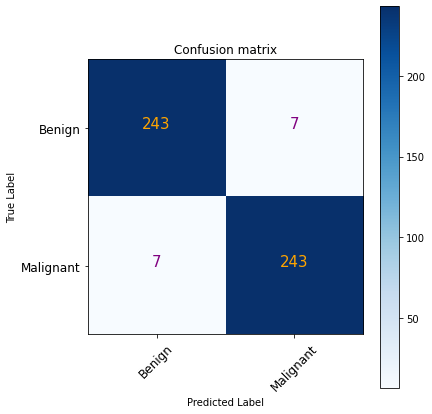

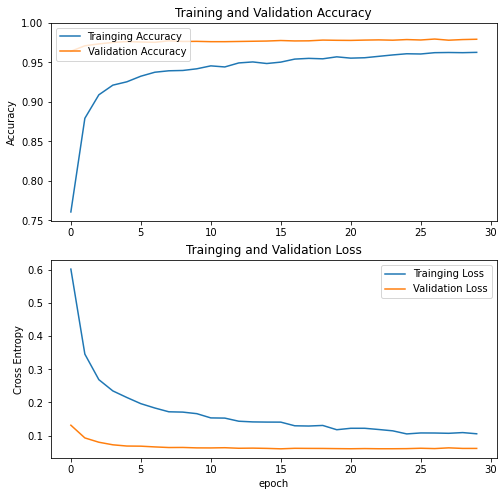

In [22]:
print(report)
plot_confusion_matrix(cm=cm,classes=['Benign','Malignant'])
plot_acc_loss(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss)

In [23]:
note="Testing Model with Cat and Dog imgs to see whether our model have bug. Be aware that due to have to many imgs for testing, testing data reduces to 500 imgs."
# note="With increased dropout value"
# note="With extra fully connected layer"
# note = "None"
# note = "With custom fully connected layer"

history_report = pd.read_csv(report_csv_path)
history_report.loc[len(history_report)]=(time.ctime(time.time()),
                                            model_name,
                                            BATCH_SIZE,
                                            epochs,
                                            learning_rate,
                                            report,
                                            cm_container,
                                            convert_list_to_str(acc),
                                            convert_list_to_str(val_acc),
                                            convert_list_to_str(loss),
                                            convert_list_to_str(val_loss),
                                            DATA_TYPE,
                                            note)
history_report.to_csv(report_csv_path,index=False)

╔═════════════════╦══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║      index      ║                                                                              -1                                                                              ║
╠═════════════════╬══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╣
║       Date      ║                                                                   Sat Nov 19 18:51:41 2022                                                                   ║
╠═════════════════╬══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╣
║      Model      ║                                                                             VGG      

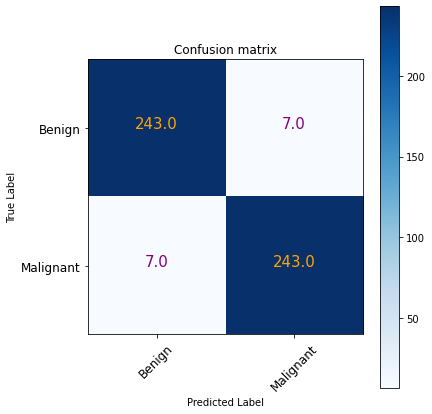

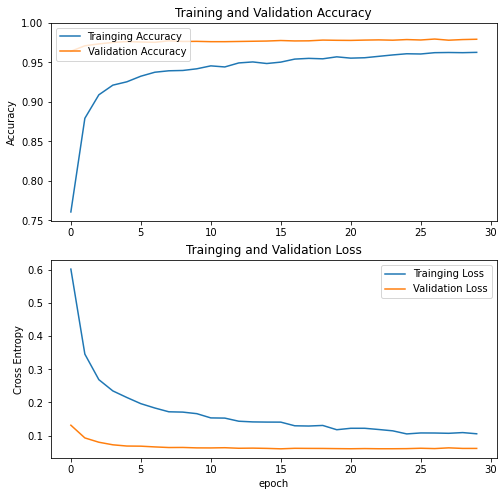

In [24]:
show_report(-1,show_plot=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

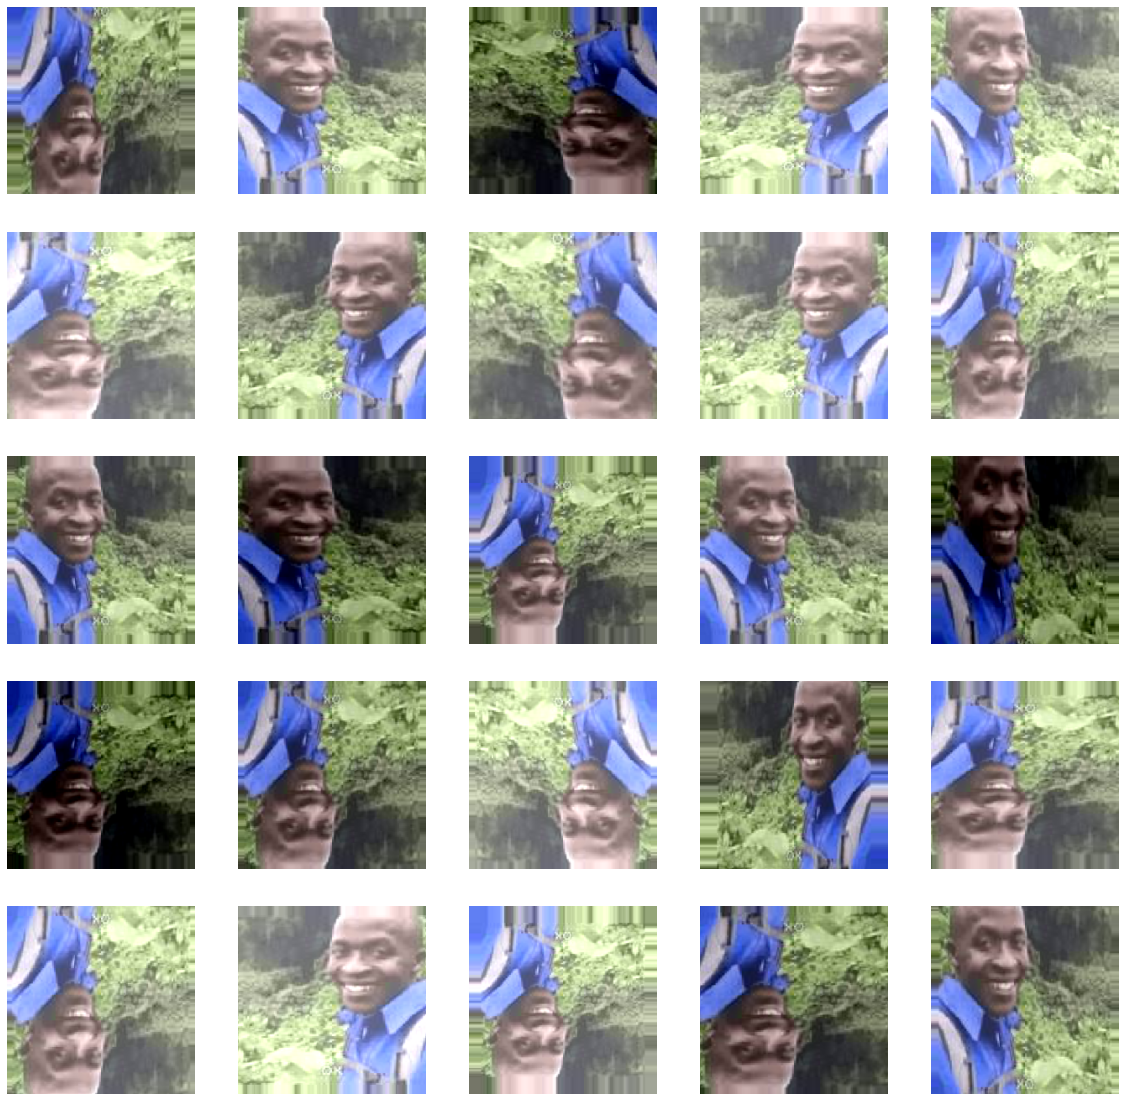

In [99]:
# #this show what we've done in image augmentation
# img = image.load_img("D:\\111project\\github\\041-111project\\data\\test.png",target_size=IMG_SIZE)
# img = image.img_to_array(img)

# img = img/255.
# plt.figure(figsize=(20,20))
# for i in range(25):
#     aug_img = da_test(img,training=True)
    
#     ax = plt.subplot(5,5,i+1)
#     plt.imshow(aug_img)
#     plt.axis("off")

In [94]:
# da_test = tf.keras.Sequential([
#         tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
#         tf.keras.layers.RandomZoom(height_factor=(0.2,-0.2),
#                                     width_factor=(0.2,-0.2),
#                                     fill_mode='nearest'),
#         tf.keras.layers.RandomBrightness(factor=0.001)
#     ],name="Data_augmentation")

In [ ]:
model.save()